## Qwen-Image & Qwen-Image Edit

In [1]:
import diffusers

# if not hasattr(diffusers.utils.constants, "MIN_PEFT_VERSION"):
# diffusers.utils.constants.MIN_PEFT_VERSION = "0.7.0"  # PEFT最低版本要求

from diffusers import DiffusionPipeline
import torch

model_name = "Qwen/Qwen-Image"
model_name = "/mnt/bn/seed-aws-va/shwai.he/models/Qwen/Qwen-Image"
# Load the pipeline
if torch.cuda.is_available():
    torch_dtype = torch.bfloat16
    device = "cuda"
else:
    torch_dtype = torch.float32
    device = "cpu"

pipe = DiffusionPipeline.from_pretrained(model_name, torch_dtype=torch_dtype)
pipe = pipe.to(device)


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

tokenizer load_method: <bound method PreTrainedTokenizerBase.from_pretrained of <class 'transformers.models.qwen2.tokenization_qwen2.Qwen2Tokenizer'>> | dduf_entries: None
scheduler load_method: <bound method SchedulerMixin.from_pretrained of <class 'diffusers.schedulers.scheduling_flow_match_euler_discrete.FlowMatchEulerDiscreteScheduler'>> | dduf_entries: None
text_encoder load_method: <bound method PreTrainedModel.from_pretrained of <class 'transformers.models.qwen2_5_vl.modeling_qwen2_5_vl.Qwen2_5_VLForConditionalGeneration'>> | dduf_entries: None


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

vae load_method: <bound method ModelMixin.from_pretrained of <class 'diffusers.models.autoencoders.autoencoder_kl_qwenimage.AutoencoderKLQwenImage'>> | dduf_entries: None


The config attributes {'pooled_projection_dim': 768} were passed to QwenImageTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.


transformer load_method: <bound method ModelMixin.from_pretrained of <class 'diffusers.models.transformers.transformer_qwenimage.QwenImageTransformer2DModel'>> | dduf_entries: None


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Expected types for text_encoder: (<class 'diffusers.pipelines.qwenimage.modeling_qwen2_5_vl.Qwen2_5_VLForConditionalGeneration'>,), got <class 'transformers.models.qwen2_5_vl.modeling_qwen2_5_vl.Qwen2_5_VLForConditionalGeneration'>.


In [2]:
model = pipe.transformer
total = 0
for name, p in model.named_parameters():
    total += p.numel() 

total / 1e9

20.430401088

In [3]:
import torch
import torch.nn as nn

sparse_ratio = 0.3

def count_parameters(model, only_trainable=False, exclude_label=None):
    """
    统计模型参数量
    Args:
        model: nn.Module, 模型
        only_trainable: bool, 是否只统计可训练参数
        exclude_label: list[str], 要排除的参数名关键词
    Returns:
        参数总数 (int)
    """
    if exclude_label is None:
        exclude_label = []

    total = 0
    for name, p in model.named_parameters():
        if any(label in name for label in exclude_label):
            continue
        if only_trainable and not p.requires_grad:
            continue
        print(name)
        total += p.numel() * sparse_ratio if "mlp" in name else p.numel()
    return total


exclude_label = ["moe_gen", "vit_model", "connector", "vae2llm", "llm2vae", "time_embedder", "pos_embed"]
exclude_label = ["visual"]

model = pipe.text_encoder
print("全部参数量:", count_parameters(model, exclude_label=exclude_label) /  1e9)
# print("可训练参数量:", count_parameters(model, only_trainable=True) /  1e9)


model.language_model.embed_tokens.weight
model.language_model.layers.0.self_attn.q_proj.weight
model.language_model.layers.0.self_attn.q_proj.bias
model.language_model.layers.0.self_attn.k_proj.weight
model.language_model.layers.0.self_attn.k_proj.bias
model.language_model.layers.0.self_attn.v_proj.weight
model.language_model.layers.0.self_attn.v_proj.bias
model.language_model.layers.0.self_attn.o_proj.weight
model.language_model.layers.0.mlp.gate_proj.weight
model.language_model.layers.0.mlp.up_proj.weight
model.language_model.layers.0.mlp.down_proj.weight
model.language_model.layers.0.input_layernorm.weight
model.language_model.layers.0.post_attention_layernorm.weight
model.language_model.layers.1.self_attn.q_proj.weight
model.language_model.layers.1.self_attn.q_proj.bias
model.language_model.layers.1.self_attn.k_proj.weight
model.language_model.layers.1.self_attn.k_proj.bias
model.language_model.layers.1.self_attn.v_proj.weight
model.language_model.layers.1.self_attn.v_proj.bias
mod

In [4]:
from diffusers.pipelines.qwenimage.modeling_qwen2_5_vl import Qwen2_5_VLForConditionalGeneration

model_path = f"{model_name}/text_encoder"
pipe.text_encoder = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path, torch_dtype="auto", device_map="auto", trust_remote_code=True, 
).to(torch_dtype)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
record = True
for i, layer in enumerate(pipe.text_encoder.model.language_model.layers):
    layer.record = record
    layer.mlp.sparse_mode = "prune"    
    layer.mlp.act_sum = None
    layer.mlp.act_cnt = 0
    # layer.mlp.register_buffer("act_sum", torch.zeros(layer.mlp.intermediate_size))     # ∑|h|
    # layer.mlp.register_buffer("act_cnt", torch.tensor(0, dtype=torch.long))       # batch 计数
    


In [6]:
import json

def extract_prompts(jsonl_path, output_txt_path = None):
    prompts = []
    with open(jsonl_path, "r") as f:
        for line in f:
            data = json.loads(line)
            if "prompt" in data:
                prompts.append(data["prompt"])
    if output_txt_path is not None:
        with open(output_txt_path, "w") as f:
            for prompt in prompts:
                f.write(prompt + "\n")
    return prompts

if __name__ == "__main__":
    jsonl_path = "/mnt/bn/seed-aws-va/shwai.he/cdt-hf/eval/gen/geneval/prompts/evaluation_metadata_long.jsonl"  # Replace with your path if different
    output_txt_path = "extracted_prompts.txt"
    prompts = extract_prompts(jsonl_path, output_txt_path)
    # print(f"Extracted {len(open(output_txt_path).readlines())} prompts to {output_txt_path}")
    print(len(prompts))

553


  0%|          | 0/2 [00:00<?, ?it/s]

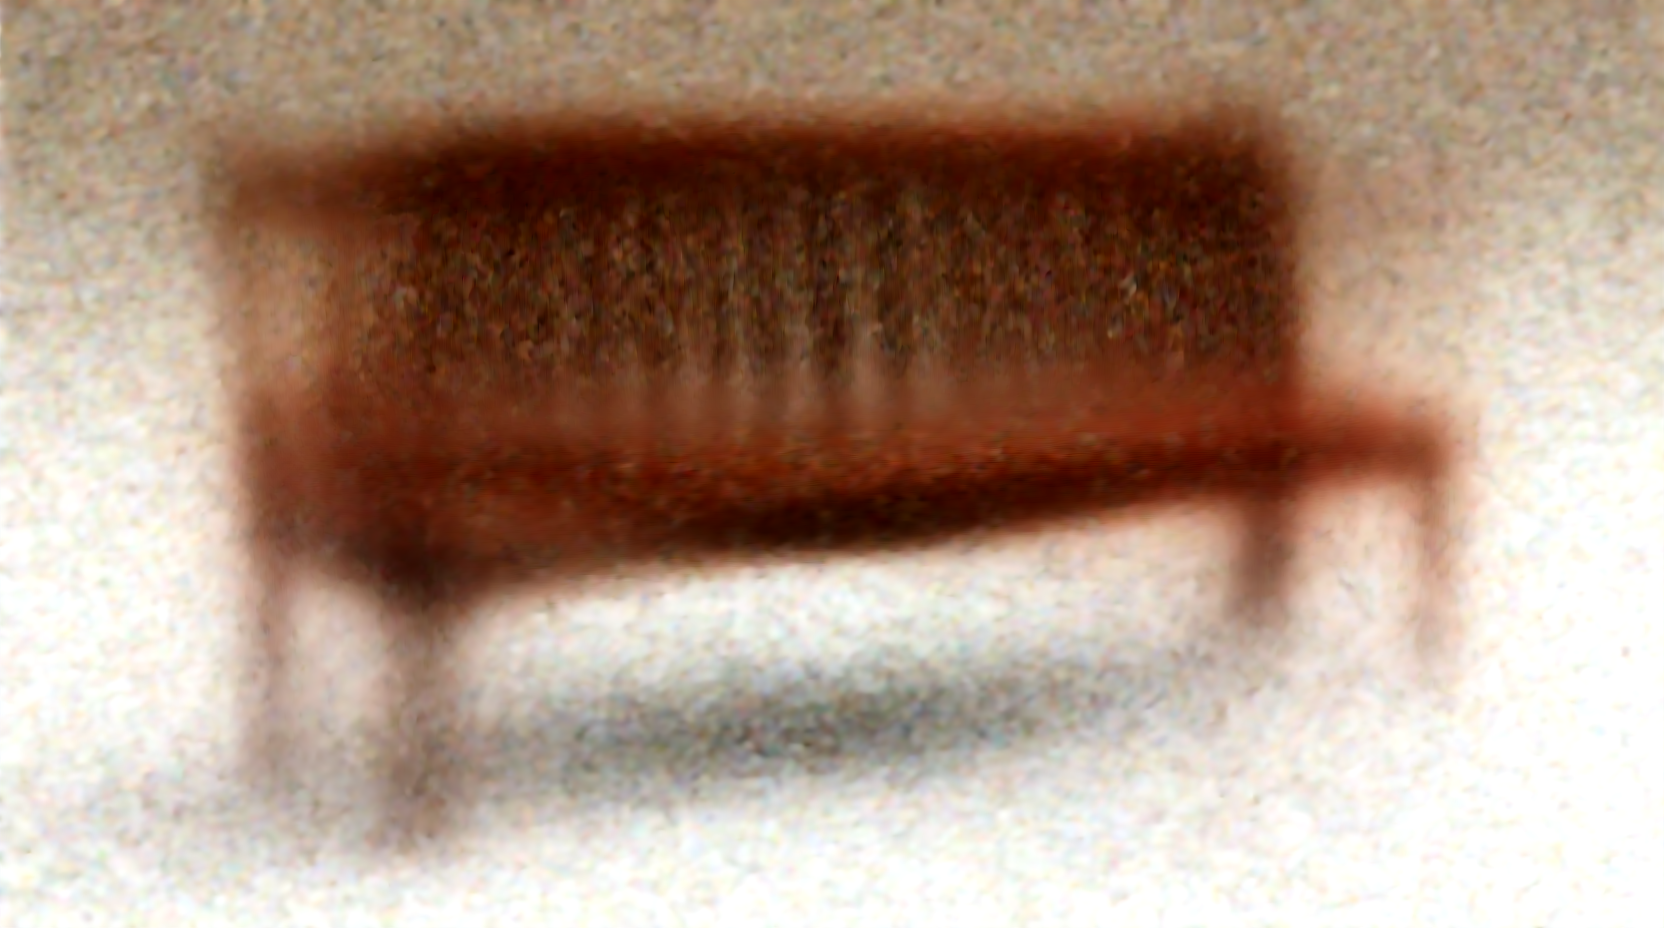

In [16]:

positive_magic = {
    "en": ", Ultra HD, 4K, cinematic composition.", # for english prompt
    "zh": ", 超清，4K，电影级构图." # for chinese prompt
}

positive_magic = {
    "en": "", # for english prompt
    "zh": "" # for chinese prompt
}

# Generate image
for i in range(30):
    prompt = '''A coffee shop entrance features a chalkboard sign reading "Qwen Coffee 😊 $2 per cup," with a neon light beside it displaying "通义千问". Next to it hangs a poster showing a beautiful Chinese woman, and beneath the poster is written "π≈3.1415926-53589793-23846264-33832795-02384197". Ultra HD, 4K, cinematic composition'''
    prompt = "A female cosplayer portraying an ethereal fairy or elf, wearing a flowing dress made of delicate fabrics in soft, mystical colors like emerald green and silver. She has pointed ears, a gentle, enchanting expression, and her outfit is adorned with sparkling jewels and intricate patterns. The background is a magical forest with glowing plants, mystical creatures, and a serene atmosphere."
    prompt = prompts[i]
    negative_prompt = " " # using an empty string if you do not have specific concept to remove


# Generate with different aspect ratios
    aspect_ratios = {
        "1:1": (1328, 1328),
        "16:9": (1664, 928),
        "9:16": (928, 1664),
        "4:3": (1472, 1140),
        "3:4": (1140, 1472),
        "3:2": (1584, 1056),
        "2:3": (1056, 1584),
    }

    width, height = aspect_ratios["16:9"]
    num_inference_steps = 2

    outputs = pipe(
        prompt=prompt + positive_magic["en"],
        negative_prompt=negative_prompt,
        width=width,
        height=height,
        num_inference_steps=num_inference_steps,
        true_cfg_scale=4.0,
        generator=torch.Generator(device="cuda").manual_seed(42)
    )
    
    image = outputs.images[0]

    # image.save("./t2i.jpg")
    display(image)
    break

In [36]:
outputs.prompt_attentions[0].size()


import torch
import numpy as np
import matplotlib.pyplot as plt
import os


def visualize_attention_sink_per_head(
    attn: torch.Tensor,
    token_labels=None,
    save_dir=None,
    topk=5,
    exclude_self=True,
):
    """
    Visualize attention sink for each head and return numeric results.

    Args:
        attn: torch.Tensor, shape [H, S, S]
        token_labels: list[str], optional labels for tokens
        save_dir: optional str, directory to save figures
        topk: int, number of top sink tokens to annotate
        exclude_self: bool, whether to zero out self-attention diagonal

    Returns:
        results: dict[head_idx -> dict]
            {
              head_idx: {
                  "sink_scores": torch.Tensor [S],
                  "top_indices": list[int],
                  "top_labels": list[str],
              }
            }
    """
    assert attn.ndim == 3, f"Expected [H,S,S], got {attn.shape}"
    H, S, _ = attn.shape
    attn = attn.detach().float().cpu()

    if token_labels is None:
        token_labels = [str(i) for i in range(S)]
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    results = {}

    for h in range(H):
        A = attn[h]
        if exclude_self:
            A = A.clone()
            A.fill_diagonal_(0.0)

        # sink score = mean over queries (i), for each key (j)
        sink_scores = A.mean(dim=0)
        top_values, top_indices = torch.topk(sink_scores, topk)
        top_labels = [token_labels[i] for i in top_indices]

        # === Heatmap === #
        plt.figure(figsize=(6, 5))
        plt.imshow(A, cmap='viridis', interpolation='nearest', aspect='auto')
        plt.colorbar(label='Attention weight')
        plt.title(f'Head {h} - Attention Heatmap')
        plt.xlabel('Key tokens')
        plt.ylabel('Query tokens')
        if save_dir:
            if not os.path.exists(f"{save_dir}/layer{l}"):
                os.makedirs(f"{save_dir}/layer{l}")
            plt.savefig(os.path.join(f"{save_dir}/layer{l}", f'head_{h:02d}_heatmap.png'), bbox_inches='tight', dpi=150)
            plt.close()
        else:
            plt.show()

        # === Sink curve === #
        plt.figure(figsize=(6, 3))
        x = np.arange(S)
        plt.plot(x, sink_scores.numpy(), marker='o', linewidth=1)
        for rank, idx in enumerate(top_indices.tolist(), 1):
            plt.scatter([idx], [sink_scores[idx]], s=50)
            plt.text(idx, sink_scores[idx].item(), f"#{rank}:{token_labels[idx]}", ha='center', va='bottom', fontsize=8)
        plt.title(f'Head {h} - Sink Scores (top-{topk})')
        plt.xlabel('Token position')
        plt.ylabel('Avg incoming attention')
        plt.tight_layout()
        if save_dir:
            if not os.path.exists(f"{save_dir}/layer{l}"):
                os.makedirs(f"{save_dir}/layer{l}")
            plt.savefig(os.path.join(f"{save_dir}/layer{l}", f'head_{h:02d}_sink.png'), bbox_inches='tight', dpi=150)
            plt.close()
        else:
            plt.show()

        results[h] = {
            "sink_scores": sink_scores,           # torch.Tensor [S]
            "top_indices": top_indices.tolist(),  # list[int]
            "top_labels": top_labels,             # list[str]
            "top_values": top_values.tolist(),    # list[float]
        }


        print(f"[Layer {l} Head {h:02d}] top-{topk} sink tokens: {list(zip(top_indices.tolist(), top_values))}")

    return results

# ==== Example usage ====
if __name__ == "__main__":
    # H, S = 28, 32
    # attn = torch.randn(H, S, S)
    # attn = torch.softmax(attn, dim=-1)  # valid attention maps
    for l in range(28):
        attn = outputs.prompt_attentions[l][0]
        S = attn.shape[-1]
        H = attn.shape[0]
        labels = [f"t{i}" for i in range(S)]

        visualize_attention_sink_per_head(attn, token_labels=labels, save_dir="./sink_qwenimage", topk=3)


[Layer 0 Head 00] top-3 sink tokens: [(10, tensor(0.0605)), (12, tensor(0.0581)), (14, tensor(0.0543))]
[Layer 0 Head 01] top-3 sink tokens: [(43, tensor(0.0209)), (62, tensor(0.0187)), (2, tensor(0.0178))]
[Layer 0 Head 02] top-3 sink tokens: [(10, tensor(0.0589)), (12, tensor(0.0512)), (14, tensor(0.0489))]
[Layer 0 Head 03] top-3 sink tokens: [(10, tensor(0.0228)), (12, tensor(0.0195)), (51, tensor(0.0192))]
[Layer 0 Head 04] top-3 sink tokens: [(10, tensor(0.0780)), (12, tensor(0.0731)), (14, tensor(0.0723))]
[Layer 0 Head 05] top-3 sink tokens: [(16, tensor(0.0149)), (2, tensor(0.0145)), (43, tensor(0.0144))]
[Layer 0 Head 06] top-3 sink tokens: [(89, tensor(0.0106)), (10, tensor(0.0104)), (12, tensor(0.0102))]
[Layer 0 Head 07] top-3 sink tokens: [(8, tensor(0.0196)), (4, tensor(0.0192)), (24, tensor(0.0176))]
[Layer 0 Head 08] top-3 sink tokens: [(4, tensor(0.0408)), (6, tensor(0.0365)), (8, tensor(0.0337))]
[Layer 0 Head 09] top-3 sink tokens: [(4, tensor(0.0388)), (8, tensor(0

In [8]:
import torch.nn.functional as F

COS_SIM = {}

TYPES = ["block", "attn", "mlp"]
for Type in TYPES:
    COS_SIM[Type] = [] 

for i, layer in enumerate(pipe.text_encoder.model.language_model.layers):

    # print(f"layer.input: {layer.input} | layer.output: {layer.output}")
    # block
    cos_sim = F.cosine_similarity(layer.input, layer.output, dim=-1)  # (total_token_num)
    cos_sim = cos_sim.mean()
    COS_SIM["block"].append(cos_sim.cpu().data.item())
    # attn
    # print(f"input_output: {cos_sim}")
    cos_sim = F.cosine_similarity(layer.input, layer.residual, dim=-1)  # (total_token_num)
    cos_sim = cos_sim.mean()
    COS_SIM["attn"].append(cos_sim.cpu().data.item())
    # print(f"input_residual: {cos_sim}")

    # mlp
    cos_sim = F.cosine_similarity(layer.residual, layer.output, dim=-1)  # (total_token_num)
    cos_sim = cos_sim.mean()
    COS_SIM["mlp"].append(cos_sim.cpu().data.item())
    # print(f"residual_output: {cos_sim}")


In [9]:
# for i, layer in enumerate(pipe.text_encoder.model.language_model.layers):
#     # layer.mlp.sparse_mode = "prune"    
#     print(layer.mlp.sparse_mode)
#     print(layer.mlp.act_sum)
#     print(layer.mlp.act_cnt)

#     # layer.mlp.register_buffer("act_sum", torch.zeros(layer.mlp.intermediate_size))     # ∑|h|
#     # layer.mlp.register_buffer("act_cnt", torch.tensor(0, dtype=torch.long))       # batch 计数
    

In [10]:
# @torch.no_grad()
# def prune_mlp(layer, keep_ratio: float = 0.5, compressed_layers: list = [], update: bool = True):
#     """
#     • keep_ratio 0.5  →  4×d → 2×d
#     • 调用前需先跑若干 batch，让 act_sum / act_cnt 累积到 >0
#     """
#     if layer.act_cnt == 0:
#         raise RuntimeError(
#             f"[Layer {layer.layer_idx}] prune_mlp() called before any forward pass."
#         )

#     # importance_i = ⟨|h_i|⟩ × ‖W_{d,i}‖₂
#     act_mean = layer.act_sum / layer.act_cnt
#     col_norm = layer.down_proj.weight.norm(dim=0).cpu()
#     score    = act_mean * col_norm

#     k = int(layer.intermediate_size * keep_ratio)
#     keep = torch.topk(score, k).indices.sort().values      # ascending order
#     keep_unsorted = torch.topk(score, k).indices

#     # print(f"keep_unsorted: {keep_unsorted}")

#     if update:  
#         if layer.layer_idx in compressed_layers:
#         #     # --- 裁剪权重 ---
#             layer.gate_proj.weight.data = layer.gate_proj.weight.data[keep]
#             layer.up_proj.weight.data   = layer.up_proj.weight.data[keep]
#             layer.down_proj.weight.data = layer.down_proj.weight.data[:, keep]
#             # --- 更新 meta ---
#             layer.intermediate_size      = k
#             layer.gate_proj.out_features = k
#             layer.up_proj.out_features   = k
#             layer.down_proj.in_features  = k

#     return keep_unsorted.tolist()



# compressed_layers = range(len(pipe.text_encoder.model.language_model.layers))
# target_layer = "mlp"
# keep_ratio = 0.5

# for layer in pipe.text_encoder.model.language_model.layers:

#     # print(layer.mlp.act_sum)
#     if target_layer == "mlp":
#         keep_und = prune_mlp(layer.mlp, keep_ratio=keep_ratio, compressed_layers=compressed_layers,)
#     elif target_layer == "attn": 
#         keep = prune_attn(layer.self_attn, keep_ratio=keep_ratio,)


## save tensors for testing

In [11]:
# all_act = []
# for i, layer in enumerate(pipe.text_encoder.model.language_model.layers):
#     # 确保在 CPU 上
#     act_sum = layer.mlp.act_sum
#     if isinstance(act_sum, torch.Tensor):
#         act_sum = act_sum.detach().cpu()
#     all_act.append(act_sum)

# # 堆叠成一个大 tensor，形状 [num_layers, ...]
# all_act_tensor = torch.stack(all_act)

# # 保存成 pt 文件
# save_path = "/mnt/bn/seed-aws-va/shwai.he/cdt-hf/scripts/eval/qwen/all_act.pt"
# torch.save(all_act_tensor, save_path)
# print(f"Saved act_sum from {len(all_act)} layers to {save_path}")



In [12]:
# # pipe.text_encoder.model.language_model

# # 取出子模块
# lm = pipe.text_encoder.model.language_model
# # lm = pipe.transformer
# # 统计总参数量
# total_params = sum(p.numel() for p in lm.parameters())
# trainable_params = sum(p.numel() for p in lm.parameters() if p.requires_grad)

# print(f"Total params: {total_params / 1e9:,}")
# print(f"Trainable params: {trainable_params /1e9:,}")

In [13]:
COS_SIM_TYPE

NameError: name 'COS_SIM_TYPE' is not defined

In [ ]:
Type = "attn"
keep_ratio = 0.2

COS_SIM_TYPE = COS_SIM[Type]
topk_weight, topk_index = torch.topk(torch.tensor(COS_SIM_TYPE), int((1 - keep_ratio) * len(COS_SIM_TYPE)), dim=-1)

for i, layer in enumerate(pipe.text_encoder.model.language_model.layers):
    if i in topk_index:
        layer.skip_mode = Type
    else: 
        layer.skip_mode = None 
    print(layer.skip_mode)

In [ ]:
for i, layer in enumerate(pipe.text_encoder.model.language_model.layers):
    layer.mlp.sparse_mode = "dense"    
    

positive_magic = {
    "en": ", Ultra HD, 4K, cinematic composition.", # for english prompt
    "zh": ", 超清，4K，电影级构图." # for chinese prompt
}

positive_magic = {
    "en": "", # for english prompt
    "zh": "" # for chinese prompt
}

# Generate image
prompt = '''A coffee shop entrance features a chalkboard sign reading "Qwen Coffee 😊 $2 per cup," with a neon light beside it displaying "通义千问". Next to it hangs a poster showing a beautiful Chinese woman, and beneath the poster is written "π≈3.1415926-53589793-23846264-33832795-02384197". Ultra HD, 4K, cinematic composition'''
prompt = "A female cosplayer portraying an ethereal fairy or elf, wearing a flowing dress made of delicate fabrics in soft, mystical colors like emerald green and silver. She has pointed ears, a gentle, enchanting expression, and her outfit is adorned with sparkling jewels and intricate patterns. The background is a magical forest with glowing plants, mystical creatures, and a serene atmosphere."
prompt = prompts[0]
negative_prompt = " " # using an empty string if you do not have specific concept to remove


# Generate with different aspect ratios
aspect_ratios = {
    "1:1": (1328, 1328),
    "16:9": (1664, 928),
    "9:16": (928, 1664),
    "4:3": (1472, 1140),
    "3:4": (1140, 1472),
    "3:2": (1584, 1056),
    "2:3": (1056, 1584),
}

width, height = aspect_ratios["16:9"]

image = pipe(
    prompt=prompt + positive_magic["en"],
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    num_inference_steps=50,
    true_cfg_scale=4.0,
    generator=torch.Generator(device="cuda").manual_seed(42)
).images[0]

# image.save("./t2i.jpg")

display(image)


In [ ]:
lm

In [ ]:
# import os
# from PIL import Image
# import torch

# from diffusers import QwenImageEditPipeline

# model_name = "Qwen/Qwen-Image-Edit"
# model_name = "/mnt/bn/seed-aws-va/shwai.he/models/Qwen/Qwen-Image-Edit"

# pipeline = QwenImageEditPipeline.from_pretrained(model_name)

# print("pipeline loaded")
# pipeline.to(torch.bfloat16)
# pipeline.to("cuda")
# pipeline.set_progress_bar_config(disable=None)

# image = Image.open("./input.png").convert("RGB")
# prompt = "Change the rabbit's color to purple, with a flash light background."

# inputs = {
#     "image": image,
#     "prompt": prompt,
#     "generator": torch.manual_seed(0),
#     "true_cfg_scale": 4.0,
#     "negative_prompt": " ",
#     "num_inference_steps": 50,
# }

# with torch.inference_mode():
#     output = pipeline(**inputs)
#     output_image = output.images[0]
#     output_image.save("output_image_edit.png")
#     print("image saved at", os.path.abspath("output_image_edit.png"))

## Training-free Compression. 

In [ ]:
# import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

# import torch

# torch.cuda.device_count()

In [ ]:
# import diffusers

# # if not hasattr(diffusers.utils.constants, "MIN_PEFT_VERSION"):
# # diffusers.utils.constants.MIN_PEFT_VERSION = "0.7.0datasets"  # PEFT最低版本要求

# from diffusers import DiffusionPipeline
# import torch

# model_name = "Qwen/Qwen-Image"
# model_name = "/mnt/bn/seed-aws-va/shwai.he/models/Qwen/Qwen-Image"
# # Load the pipeline
# if torch.cuda.is_available():
#     torch_dtype = torch.bfloat16
#     device = "cuda"
# else:
#     torch_dtype = torch.float32
#     device = "cpu"

# pipe = DiffusionPipeline.from_pretrained(model_name, torch_dtype=torch_dtype)
# pipe = pipe.to(device)

In [ ]:
# import torch

# # 假设你已经有 pipe 对象
# # component = pipe.text_encoder
# component = pipe.transformer


# # 统计总参数量
# total_params = sum(p.numel() for p in component.parameters())

# # 统计可训练参数量
# trainable_params = sum(p.numel() for p in component.parameters() if p.requires_grad)

# print(f"Total parameters: {total_params / 1e9:,}")
# print(f"Trainable parameters: {trainable_params / 1e9:,}")

In [ ]:
# pipe
